In [13]:
# creating paths to src and data folders in the repo
import sys
import pathlib
src_path = pathlib.Path().absolute().parent.parent / "src"
data_path = pathlib.Path().absolute().parent.parent / "data"

# train test split paths
train_path = data_path / 'binary_tts/train'
test_path = data_path / 'binary_tts/test'
val_path = data_path / 'binary_tts/val'

# add src path to sys.path so it is searched in import statements
sys.path.append(str(src_path))

# basic imports for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# silence max image size warning
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000 

# import modeling packages
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# modeling metrics
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

changes to data generators:
    
    interpolation 'nearest' -> 'bicubic'
    
    target_size 150x150 -> 200x200
    

In [14]:
train_generator = ImageDataGenerator().flow_from_directory(str(train_path),
                                                           target_size=(300, 300),
                                                           batch_size=20,
                                                           class_mode='binary',
                                                           interpolation='bicubic')
test_generator = ImageDataGenerator().flow_from_directory(str(test_path),
                                                          target_size=(300, 300),
                                                          batch_size=20,
                                                          class_mode='binary',
                                                          interpolation='bicubic',
                                                          shuffle=False)
val_generator = ImageDataGenerator().flow_from_directory(str(val_path),
                                                         target_size=(300, 300),
                                                         batch_size=20,
                                                         class_mode='binary',
                                                         interpolation='bicubic',
                                                         shuffle=False)

Found 6000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


changes to model architecture:
    
    input_shape 150x150 -> 200x200
    
    num conv2d layers 2 -> 1
    
    output num_nodes 2 -> 1
    
    output_activation 'softmax -> sigmoid'
    
    MaxPooling pool_size 2x2 -> 5x5

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(35, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D((5, 5)))
model.add(layers.Flatten())
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 35)      980       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 35)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 121835)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                4873440   
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

changes to fit:
    
    epochs 10 -> 5
    
    steps_per_epoch 200 -> 300

In [17]:
model.fit(
        train_generator,
        steps_per_epoch=300,
        epochs=6,
        validation_data=test_generator,
        validation_steps=10)

Epoch 1/6
294/300 [============================>.] - ETA: 21s - loss: 24.4641 - accuracy: 0.5274

/opt/anaconda3/envs/new_capstone-env/lib/python3.6/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


300/300 [==============================] - 1086s 4s/step - loss: 24.0031 - accuracy: 0.5272 - val_loss: 0.7829 - val_accuracy: 0.5450
Epoch 2/6
300/300 [==============================] - 1141s 4s/step - loss: 0.9813 - accuracy: 0.5727 - val_loss: 0.7667 - val_accuracy: 0.6000
Epoch 3/6
300/300 [==============================] - 1167s 4s/step - loss: 0.7054 - accuracy: 0.6083 - val_loss: 0.6911 - val_accuracy: 0.6350
Epoch 4/6
300/300 [==============================] - 1170s 4s/step - loss: 0.6192 - accuracy: 0.6618 - val_loss: 0.6619 - val_accuracy: 0.5900
Epoch 5/6
300/300 [==============================] - 1165s 4s/step - loss: 0.5679 - accuracy: 0.7015 - val_loss: 0.6692 - val_accuracy: 0.6500
Epoch 6/6
300/300 [==============================] - 1173s 4s/step - loss: 0.5306 - accuracy: 0.7217 - val_loss: 0.7370 - val_accuracy: 0.6700


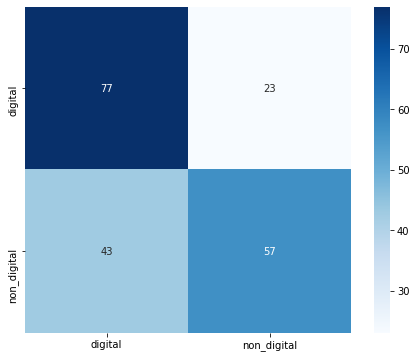

In [20]:
conf_mat = confusion_matrix(test_generator.classes, model.predict_classes(test_generator))

class_names = list(test_generator.class_indices.keys())

fig, ax = plt.subplots(figsize=(8,6))
model_10_path = pathlib.Path().absolute().parent.parent / 'reports/figures/mod_10_heatmap.png'
ax.set_ylim([0,1])
sns.heatmap(conf_mat, xticklabels=class_names, yticklabels=class_names, ax=ax, square=True, annot=True, cmap='Blues')
plt.savefig(model_10_path)

In [19]:
accuracies = []
for i in range(0, 2):
    acc = conf_mat[i][i] / sum(conf_mat[i])
    accuracies.append(acc)
accuracies

[0.77, 0.57]